# First Steps on training a Deep Learning model

Learning from  data consists in using examples $\{(x_k,y_k)\}_{1\leq k \leq n} \in (\mathcal{X},\mathcal{Y})$ to build a parametric map $\phi: \mathcal{X} \mapsto \mathcal{Y}$ that accurately predicts the label $y_{n+1}$ of any new data sample $x_{n+1}$, that is: $y_{n+1} \approx \phi(x_{n+1})$. A **{index}``Deep Neural Network``** (DNN), in its simplest form, is a **{index}``compositional map``** that may be written as:
\begin{eqnarray*}
  \phi_{f;\theta}:=f^{(d)} (g^{(d)}\cdots f^{(1)}(g^{(1)}(\boldsymbol{X}))),
\end{eqnarray*}
where each $f^{(l)}$ is a non-linear function called **{index}``activation function``** and each $g^{(l)}$ is usually an affine application defined by its weight matrix $\mathbf{W}^{(l)}$ and bias vector $b^{(l)}$. We denote the paramater of the model by $\theta$, i.e. $\theta=[\mathbf{W}^{(1)},b^{(1)},\ldots,\mathbf{W}^{(d)},b^{(d)}]$


In the training process, we would usually tune the parameters $\theta$ so as to minimise the difference between the labels (ideal maps $y_{k}$) and the outputs of the DNN (estimated maps $\hat{y}_{k}=\phi_{f;\theta}(x_k)$) at any training instance $x_{k}$, such that the difference goes to zero as the number of samples $N$ increases. For that, we define a **{index}``loss function``** $\mathit{loss}(y_{k},\hat{y}_{k})$ that represents the difference between the labels and the DNN
output.

Usually, the training process, minimise the called **{index}`empirical risk`**, by averaging the loss function on a large set of training examples $(x_k,y_k)_{1\leq k \leq N}$,
\begin{equation}
\hat{\theta} =\arg\min_{\theta} \sum_{i=0}^{N} \mathit{loss}(y_k,\phi_{f;\theta}(x_k)).
\end{equation}

This minimization is usually done via **{index}``stochastic gradient descend``** (SGD). 
SGD starts from certain initial $\theta$ and after iteratively updates each parameter by moving it in the direction of the negative gradient with respect to the loss function. 

The computation of gradient with respect to the loss function is done via a direct application of the chain rule in networks, called **{index}``back-propagation``**. 

The term stochastic in SGD indicates that a random small number of training samples, called a batch is used in the gradient calculation.  A pass of the whole training set is called an **{index}``epoch``**. Usually, after each epoch, the error on a validation dataset is evaluated and when it stabilizes the training is complete.

In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
use_samples=5000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train=x_train[0:use_samples]
y_train=y_train[0:use_samples]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (5000, 28, 28, 1)
5000 train samples
10000 test samples


In [3]:
from morpholayers import *
from morpholayers.layers import *
from morpholayers.constraints import *

In [4]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model

In [5]:
batch_size = 128
epochs = 50


In [6]:
nfilterstolearn=8
filter_size=5

In [7]:
from sklearn.metrics import classification_report,confusion_matrix


## Defining an architecture

One of the fundamental point is the selection of an adequate **{index}``architecture``**, i.e. the structure of composition between layers: number of layers, dimension of each layer's output, size of the convolution kernels, type of activation functions. We will train a clasical architecture by using as first layer different morphological operators.

In [8]:
xin=Input(shape=input_shape)
xlayer=Dilation2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size))(xin)
x=MaxPooling2D(pool_size=(2, 2))(xlayer)
x=Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x=MaxPooling2D(pool_size=(2, 2))(x)
x=Flatten()(x)
x=Dropout(0.5)(x)
xoutput=Dense(num_classes, activation="softmax")(x)
modeli=Model(xin,outputs=xoutput)

## Visualizing an architecture

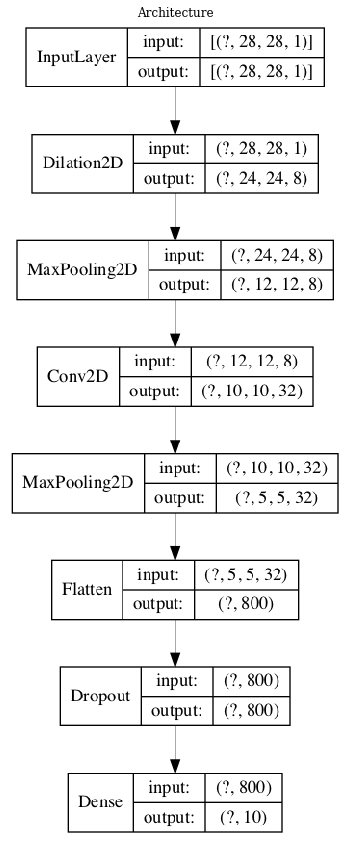

Number of Parameters by Layer
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
dilation2d (Dilation2D)      (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (N

In [9]:
tensorflow.keras.utils.plot_model(modeli, to_file='model.png',show_shapes=True,show_layer_names=False)
plt.figure(figsize=(20,15))
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.title('Architecture')
plt.show()
print('Number of Parameters by Layer')
modeli.summary()

## Optimizer and Callbacks

The model is compile to use the categorical crossentropy as loss function.

The optimizers is **{index}`ADAM`** with a learning rate of .01.
Other options for the optimizer can considered ([keras optimizers](https://keras.io/api/optimizers/))


In [10]:
modeli.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(lr=.01), metrics=["accuracy"])

**{index}`Callbacks`** allow us to perform actions at various stages of training:
1. **{index}`EarlyStopping`** stops the training process if there is not improving in the validation loss after 5 (patience) epochs 
2. **{index}`ReduceLROnPlateau`** multiplies learning rate by .5 (factor)  is there is not improving in the validation loss after 2 (patience) epochs. 

## Fitting a model

In [11]:
historyi=modeli.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(patience=2,factor=.5)],verbose=0)

## Visualizing model training history

In [12]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss by Epochs')
    plt.grid('on')
    plt.legend()
    plt.show()
    plt.plot(history.history['accuracy'],label='acc')
    plt.plot(history.history['val_accuracy'],label='val_acc')
    plt.grid('on')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Epochs')
    plt.legend()
    plt.show() 

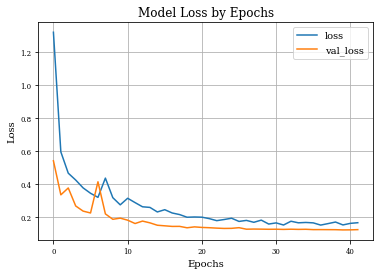

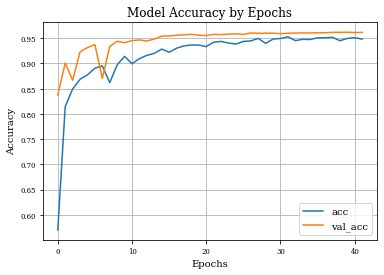

In [13]:
plot_history(historyi)

## Reporting results
In the following cell the [**{index}`confusion matrix`**](https://en.wikipedia.org/wiki/Confusion_matrix) is calculed and represented as a heatmap.

[[ 963    1    3    0    0    2    5    2    4    0]
 [   0 1119    4    1    1    2    2    0    6    0]
 [   3    1 1004    4    2    1    0    9    7    1]
 [   0    0    6  974    0   13    0    7    8    2]
 [   1    2    3    0  944    0    7    2    2   21]
 [   3    1    0    9    1  869    3    1    4    1]
 [   6    5    0    0    4    7  934    0    2    0]
 [   0    5   18    4    1    0    0  951    5   44]
 [  21    1    8    9    5   12    2    7  894   15]
 [   3    7    2    9   10    8    1    8    4  957]]


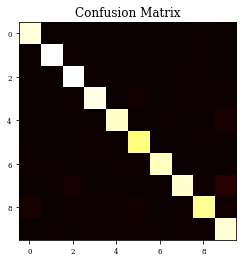

In [14]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(modeli.predict(x_test),axis=1)
CM=confusion_matrix(Y_test, y_pred)
print(CM)
plt.imshow(CM,cmap='hot',vmin=0,vmax=1000)
plt.title('Confusion Matrix')
plt.show()

    

Additionally a **{index}`classification report`** is also shown.


**{index}`Precision`** also called **{index}`positive predictive value`**, is the fraction of relevant instances among the retrieved instances.

**{index}`Recall`** also called **{index}`sensitivity`**, is the fraction of the total amount of relevant instances that were actually retrieved.

[**{index}`F1 score`**](https://en.wikipedia.org/wiki/F1_score) is the harmonic mean of the precision and recall.

**{index}`micro-average`** and **{index}`macro-average`** will compute different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average, whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification problem, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In [15]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.97      0.96       892
           6       0.98      0.97      0.98       958
           7       0.96      0.93      0.94      1028
           8       0.96      0.92      0.94       974
           9       0.92      0.95      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Visualizing learned filters

In [16]:
   
def plot_output_filters(model,idx=0):
    fig=plt.figure()
    Z=model.predict(x_train[(idx):(idx+1),:,:,:])
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[0,:,:,i],cmap='gray',vmax=Z.max(),vmin=Z.min())
        #plt.colorbar()
    fig.suptitle('Output of Learned Filters for an example')

def plot_filters(model):
    Z=model.layers[-1].get_weights()[0]
    fig=plt.figure()
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[:,:,0,i],cmap='RdBu',vmax=Z.max(),vmin=Z.min())
    fig.suptitle('Learned Filters')
    

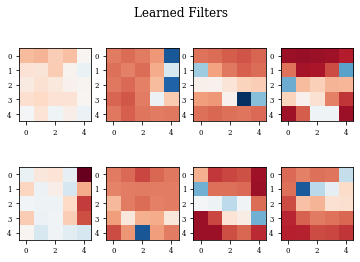

In [17]:
modellayer=Model(xin,outputs=xlayer)
plot_filters(modellayer)

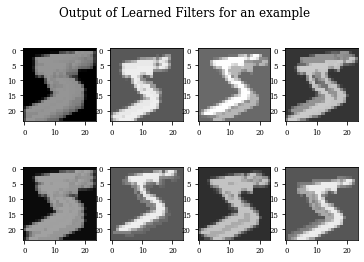

In [18]:
plot_output_filters(modellayer,idx=0)